In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import scipy

In [2]:
def cov(s_i, s_j, var_p=1.0, l=1.0, norm=2):
    '''
    Squarred exponential function.

    Parameters
    ----------
    s_i: array_like
        First point.
    s_j: array_like
        Second point.
    var_p: float
        Prior varince.
    l: float
        Length scale.

    Returns
    -------
    float
        The covariance of the two points.
    '''
    if isinstance(s_i, np.ndarray):
        return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.linalg.norm(s_i - s_j, norm)**2 )
    else:
        return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.abs(s_i - s_j)**2 )

def phi(s, S, K_i_inv, var_p=1.0, l=1.0):
    '''
    Computes the :math:´\phi´ according to the position :math:´s´.

    Parameters
    ----------
    s: array_like
        The position to interpolate.
    S: array_like
        The known sampled positions.
    K_i_inv: array_like
        The i-th row of the inverse system matrix.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    float
        The :math:´phi´ of the i-th row solving the system of equations.
    '''
    K_i = np.array([cov(s_i, s, var_p, l) for s_i in S])
    phi_i = K_i_inv * K_i
    return np.sum(phi_i)

def kriging(S, f, var, s_interpolated, var_p, l):
    '''
    Computes a multivatiate random field using kriging based on the observed points `S` and values `f`.

    Parameters
    ----------
    S: array_like
        Sampled points positions.
    f: array_like
        Values observed at the sampled points.
    var: array_like
        The (estimated) variance of the observed values.
    s_interpolated: array_like
        Points to interpolate the new values.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    mu_interpolated: array_like
        The interpolated mean values.
    var_interplated: array_like
        The interpolated variance.
    '''
    K = np.array([
    [cov(S[i], S[j], var_p, l) for j in range(len(f))]
        for i in range(len(f))])
    K += np.diag(var)

    K_inv = np.linalg.inv(K)

    mu_interpolated = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) for i in range(len(f))]
    for s in s_interpolated]) @ f

    var_sum = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) * cov(S[i], s, var_p, l) for i in range(len(f))]
    for s in s_interpolated])

    var_interpolated = np.array([cov(s, s, var_p, l) for s in s_interpolated]) - np.sum(var_sum, axis=1)

    return mu_interpolated, var_interpolated

def piecewise_kriging(S, f, var_i, scale, var_p, l, confidence=3):
    influence_width = int(np.ceil(confidence * l))

    result_x = []
    result_mu = []
    result_var = []
    for i in range(influence_width, S.shape[0] - influence_width - 1):
        f_subset = f[i-influence_width:i+influence_width+2]
        var_i_subset = var_i[i-influence_width:i+influence_width+2]
        s_subset = S[i-influence_width:i+influence_width+2]

        s_interpolated = np.linspace(s_subset[0], s_subset[-1], (s_subset.shape[0] - 1) * scale + 1)

        mu_interpolant, var_interpolant = kriging(s_subset, f_subset, var_i_subset, s_interpolated, var_p, l)

        s_segment = s_interpolated[influence_width * scale: (influence_width + 1) * scale + 1 ]
        mu_segment = mu_interpolant[influence_width * scale: (influence_width + 1) * scale + 1 ]
        var_segment = var_interpolant[influence_width * scale: (influence_width + 1) * scale + 1 ]

        result_x.append( s_segment )
        result_mu.append( mu_segment )
        result_var.append( var_segment )

    result_x = np.array(result_x)
    result_mu = np.array(result_mu)
    result_var = np.array(result_var)
    result_std = np.sqrt(result_var)

    return result_x, result_mu, result_var

In [3]:
dax = yf.Ticker('^GDAXI')
df = dax.history('1y', '1d')
df = df['Close']

window_size = 5
mu = []
var = []
x = []
for i in range(window_size, df.shape[0], window_size):
    window = df.iloc[i - window_size : i]
    
    x.append(window.index[0].timestamp() / 10**9 / 1.632096)
    mean = window.mean()
    variance = window.var()
    mu.append(mean)
    var.append(variance)

x = np.array(x)
mu = np.array(mu)
var = np.array(var)

print(x)

[1.00005294 1.0004235  1.00079407 1.00116464 1.0015352  1.00190577
 1.00227634 1.0026469  1.00301747 1.00338804 1.0037586  1.00412917
 1.00449974 1.0048703  1.00529381 1.00571731 1.00608788 1.00645844
 1.00682901 1.00719958 1.00757014 1.00794071 1.00831128 1.00868184
 1.00905241 1.00942298 1.00979354 1.01016411 1.01053467 1.01090524
 1.01148756 1.01185813 1.01222869 1.01259926 1.01296983 1.01334039
 1.01371096 1.01408152 1.01445209 1.01482266 1.01519322 1.01556379
 1.01593436 1.01630492 1.01667549 1.01704606 1.01741662 1.01778719
 1.01815776 1.01852832 1.01889889]


51 51


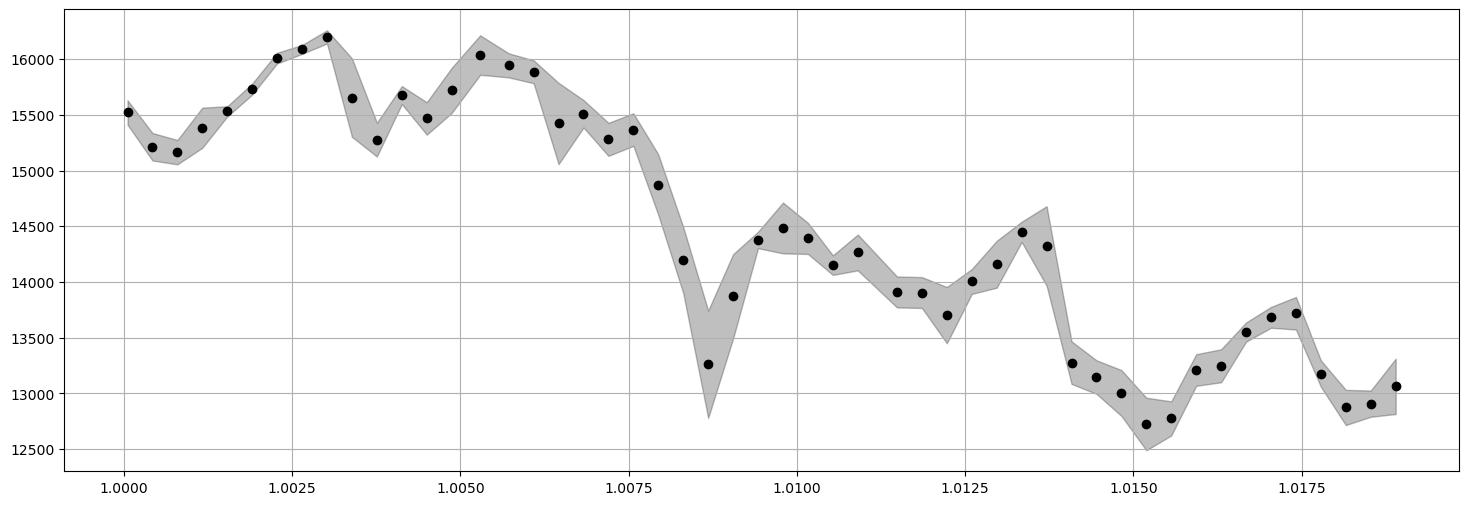

In [4]:
print(len(x), len(mu))

plt.figure(figsize=(18,6))
plt.plot(x, mu, marker='o', ls='none', c='k')
plt.fill_between(x, mu - np.sqrt(var), mu + np.sqrt(var), color='k', alpha=0.25)
plt.grid()
plt.show()

In [25]:
S = np.array([x]).T
f = mu
var_i = var

scale = 8

confidence = 3.0
l = 0.001
var_p = 100000.0

influence_width = confidence * l

tree = scipy.spatial.KDTree(S)

result_x = []
result_mu = []
result_var = []
for idx,p in enumerate(S):
    points_of_interest = tree.query_ball_point(p, influence_width, return_sorted=True)

    s_subset = S[points_of_interest]
    f_subset = f[points_of_interest]
    var_i_subset = var_i[points_of_interest]

    s_interpolated = np.array([np.linspace(s_subset[i], s_subset[i+1], scale + 1) for i in range(len(s_subset) - 1)]).flatten()
    w = len(s_interpolated) // scale

    mu_interpolant, var_interpolant = kriging(s_subset, f_subset, var_i_subset, s_interpolated, var_p, l)

    result_x.append(s_interpolated[2*scale:3 * scale])
    result_mu.append(mu_interpolant[2*scale:3 * scale])
    result_var.append(var_interpolant[2*scale:3 * scale])

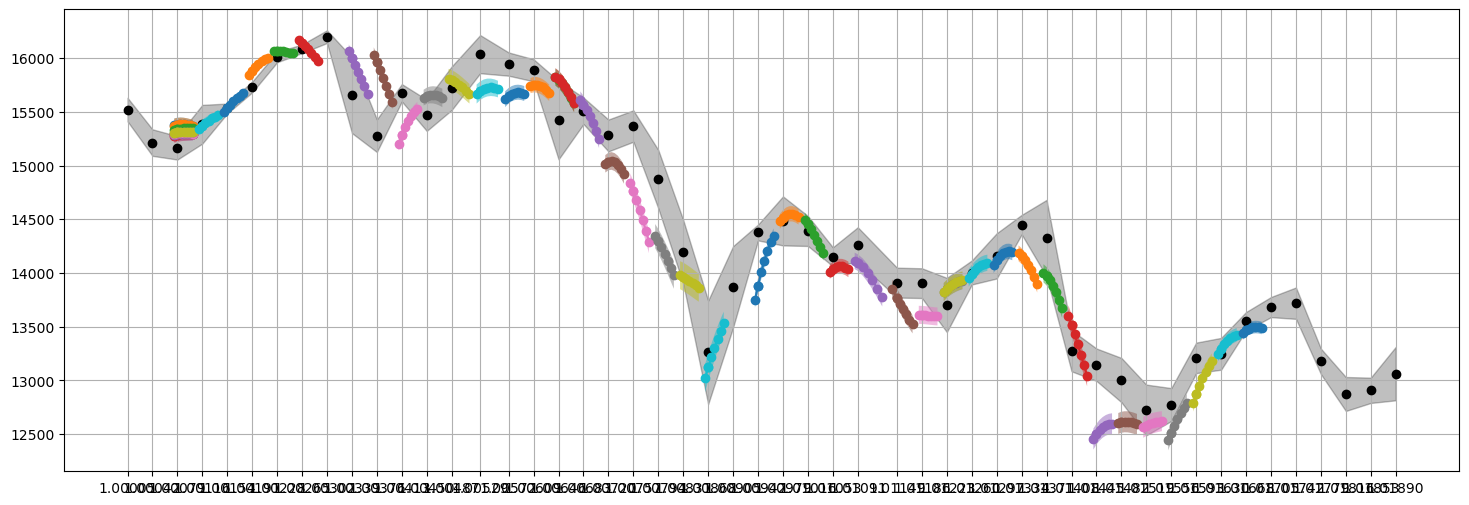

In [26]:
result_std = [np.sqrt(var_i) for var_i in result_var]

plt.figure(figsize=(18,6))
plt.plot(x, mu, marker='o', ls='none', c='k')
plt.fill_between(x, mu - np.sqrt(var), mu + np.sqrt(var), color='k', alpha=0.25)
for i in range(np.shape(result_x)[0]):
    plt.plot(result_x[i], result_mu[i], marker='o')
    segement = plt.fill_between(result_x[i], result_mu[i] - result_std[i], result_mu[i] + result_std[i], alpha=0.5)

plt.xticks(x)
plt.grid()
plt.show()